## Course: TM10007 - Machine learning
Editors: Lishia Vergeer, Amy Roos, Maaike Pruijt, Hilde Roording.

Description: The aim of this code is to predict the tumor grade of glioma’s(high or low) before surgery, 
based on features extracted from a combination of four MRI images: 
T2-weighted, T2-weighted FLAIR and T1-weighted before and after injection of contrast agent.

#### Import packages

In [180]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn as sns

# Import code
from brats.load_data import load_data

# Performance 
from sklearn.model_selection import train_test_split
from sklearn import decomposition
import seaborn
from matplotlib import pyplot as plt


# Pipeline and gridsearch
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# scaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


#Machine learning classifiers
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor



#### Load data

In [181]:
data_brats = load_data()

# Convert to dataframe
X = pd.DataFrame(data_brats)

# Print data 
print(f'The number of samples in data_brats: {len(X.index)}')
print(f'The number of columns in data_brats: {len(X.columns)}')

The number of samples in data_brats: 167
The number of columns in data_brats: 725


c:\Users\hilde\Python\TM10007_Machine_Learning\TM10007\brats\load_data.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data2)


#### Split data in X and y
Split in X (data) and y (label)

In [182]:
# split column label from dataset X
y = X.pop('label')

#### Split data in train and test set
This function creates a panda dataframe and splits the data into test and train components.
This is done with test_size variable and the function train_test_split from the sklearn module.
Returns a train set with the data of 80% and a test set of 20% of the subjects.



In [183]:
# Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)  


#### Divergent values to NaN

In [184]:

# infinity to NaN
X_train[X_train==np.inf]=np.nan
X_test[X_test==np.inf]=np.nan

# non-numeric features to NaN
X_train = X_train.replace(['#DIV/0!'], np.nan)
X_train = X_train.apply(pd.to_numeric, errors='coerce')

X_test  = X_test.replace(['#DIV/0!'], np.nan)
X_test = X_test.apply(pd.to_numeric, errors='coerce')



#### Visualising outliers

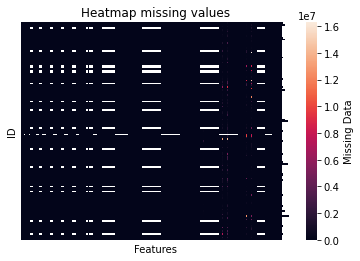

In [185]:
sns.heatmap(X_train, yticklabels=False, xticklabels=False, cbar_kws={'label': 'Missing Data'})
plt.title('Heatmap missing values')
plt.xlabel('Features')
plt.ylabel('ID')
plt.savefig("visualizing_missing_data_with_heatmap.png", dpi=100)

#### Outliers to NaN



In [186]:
for column in X_train:
    # Removing outliers
    q1 = X_train[column].quantile(0.25)
    q3 = X_train[column].quantile(0.75)
    iqr = q3-q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    #print(column)

    # Information outliers
    outliers = [x for x in X_train[column] if x < lower or x > upper]
    outliers_removed = [x for x in X_train[column] if x >= lower and x <= upper]
    #print('Identified outliers: %d' % len(outliers))
    #print('Non-outlier observations: %d' % len(outliers_removed))


    X_train[column].loc[X_train[column] > upper] = np.nan
    X_train[column].loc[X_train[column] < lower] = np.nan

C:\Users\hilde\AppData\Local\Temp\ipykernel_26804\2305262603.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column].loc[X_train[column] > upper] = np.nan


#### Visualising missing data after removing outliers

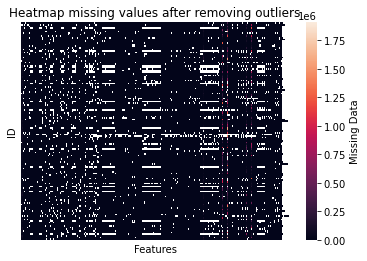

In [187]:
sns.heatmap(X_train, yticklabels=False, xticklabels=False, cbar_kws={'label': 'Missing Data'})
plt.title('Heatmap missing values after removing outliers')
plt.xlabel('Features')
plt.ylabel('ID')
plt.savefig("visualizing_missing_data_with_heatmap_outliers.png", dpi=100)


#### Drop columns

In [188]:
# If the total number of NaN observations in a column are greater than 40%, delete the entire column.
perc = 40.0
min_count = int(((100-perc)/100)*X_train.shape[0] + 1)
X_train_drop = X_train.dropna(axis=1, thresh=min_count)
X_labels = X_train_drop.keys()

X_test_drop = X_test[X_labels]

#### Fill the NaN observations.


In [189]:
data_fill_train = X_train_drop.fillna(X_train_drop.mean()) 
data_fill_test = X_test_drop.fillna(X_test_drop.mean()) 

#### Scale features

In [190]:
# Scaler
scaler = StandardScaler()
scaler.fit(data_fill_train)
X_train_scaled = scaler.transform(data_fill_train)
X_test_scaled = scaler.transform(data_fill_test)

#### Transform features

In [191]:
# Perform a PCA
pca = decomposition.PCA(n_components=5)
pca.fit(X_train_scaled) 
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


#### Test Classifiers

In [192]:
"""
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
classifiers = (KNeighborsClassifier(), RandomForestClassifier(), SVC(kernel="rbf", C=0.025, probability=True), NuSVC(probability=True))

for cls in classifiers:
    model = cls
    model.fit(X_train_pca, y_train)

    preds = model.predict(X_train_pca)

    metrics.plot_confusion_matrix(model, X_train_pca, y_train)
    display_labels =['Negative', 'Positive']


    confusion = metrics.confusion_matrix(y_train, preds)
    accuracy = metrics.accuracy_score(y_train, preds)
    sensitivity = metrics.recall_score(y_train, preds, pos_label='GBM')
    specificity = metrics.recall_score(y_train, preds, pos_label='LGG')

    #table = {'classifier': cls, 'accuracy': accuracy, 'Sensitivity', sensitivity, 'Specificity': specificity}
    print(f'For classifier: {cls}, Accuracy: {accuracy}, Sensitivity: {sensitivity}, Specificity{specificity}')

"""

'\n#Confusion matrix, Accuracy, sensitivity and specificity\nfrom sklearn.metrics import confusion_matrix\nimport matplotlib.pyplot as plt\nfrom sklearn.datasets import make_classification\nfrom sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.svm import SVC\nclassifiers = (KNeighborsClassifier(), RandomForestClassifier(), SVC(kernel="rbf", C=0.025, probability=True), NuSVC(probability=True))\n\nfor cls in classifiers:\n    model = cls\n    model.fit(X_train_pca, y_train)\n\n    preds = model.predict(X_train_pca)\n\n    metrics.plot_confusion_matrix(model, X_train_pca, y_train)\n    display_labels =[\'Negative\', \'Positive\']\n\n\n    confusion = metrics.confusion_matrix(y_train, preds)\n    accuracy = metrics.accuracy_score(y_train, preds)\n    sensitivity = metrics.recall_score(y_train, preds, pos_label=\'GBM\')\n    specificity = metrics.recall_score(y_train, preds, pos_label=\'LGG\')\n\n    #table =

#### Cross validation

In [193]:
# Create a cross-validation object
cv = KFold(n_splits=5, shuffle= True, random_state = 1)

X = X_train_pca

y = y_train.values
y = np.where(y=='GBM', 1, y)
y = np.where(y=='LGG', 0, y)
y = y.tolist()

classifiers = (KNeighborsClassifier(), RandomForestClassifier(), SVC())
scores = ['accuracy', 'recall', 'roc_auc']

score_list = []
for cls in classifiers:
    score_dict = {'Classifier':[cls]}
    score_list.append(score_dict)
    for score in scores:
        list_scores = cross_val_score(cls, X, y, scoring = score , cv=cv)
        mean = np.mean(list_scores)
        score_dict ={score: [mean]}
        score_list.append(score_dict)
        print(f'The classifier{cls} has mean {score} of:', mean)
        
dict1 = score_list[0] | score_list[1] | score_list[2] | score_list[3]
dict2 = score_list[4] | score_list[5] | score_list[6] | score_list[7]
dict3 = score_list[8] | score_list[9] | score_list[10] | score_list[11]

score_frame1 = pd.DataFrame(dict1)
score_frame2 = pd.DataFrame(dict2)
score_frame3 = pd.DataFrame(dict3)
frames = [score_frame1, score_frame2, score_frame3]
score_frame = pd.concat(frames)
print(score_frame)


The classifierKNeighborsClassifier() has mean accuracy of: 0.8421652421652421
The classifierKNeighborsClassifier() has mean recall of: 0.9053652230122818
The classifierKNeighborsClassifier() has mean roc_auc of: 0.8751346692523164
The classifierRandomForestClassifier() has mean accuracy of: 0.8418803418803418
The classifierRandomForestClassifier() has mean recall of: 0.8936005171299289
The classifierRandomForestClassifier() has mean roc_auc of: 0.8883564964447318
The classifierSVC() has mean accuracy of: 0.8720797720797722
The classifierSVC() has mean recall of: 0.9434173669467787
The classifierSVC() has mean roc_auc of: 0.915140056022409
                 Classifier  accuracy    recall   roc_auc
0    KNeighborsClassifier()  0.842165  0.905365  0.875135
0  RandomForestClassifier()  0.841880  0.893601  0.888356
0                     SVC()  0.872080  0.943417  0.915140


#### Random forest model with hyperparameters 
First define some hyperparameters 


In [194]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree 
max_depth = [2, 4]
# Minimum number of samples required to split a node
# min_sample_split = [2, 3]
# Minimum number of samples required at each leaf node
#min_sample_leaf = [1, 2]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create a dictionary of the hyperparameters above (create a parameter grid)
param_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth':max_depth
    } 

print(param_grid)

# param_grid = {
#     'n_estimators': n_estimators, 
#     'max_features': max_features, 
#     'max_depth':max_depth, 
#     'min_sample_split': min_sample_split, 
#     'min_sample_leaf':min_sample_leaf, 
#     'bootstrap': bootstrap }
# print(param_grid)

# Create an insance of the classifier
rf_model = RandomForestClassifier()

{'n_estimators': [10, 13, 17, 21, 24, 28, 32, 35, 39, 43, 46, 50, 54, 57, 61, 65, 68, 72, 76, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4]}


Doing a random gridsearch 

In [195]:
# Doing a random grid search 
# A randomised grid search will perform worse than a gridsearch but it is faster 
rf_random_grid = RandomizedSearchCV(estimator = rf_model, param_distributions = param_grid, cv = 10, verbose = 2, n_jobs = 4)
rf_random_grid.fit(X_train_pca, y_train)
rf_random_grid.best_params_

results = pd.DataFrame(rf_random_grid.cv_results_)
print(results)
#print (f' Train Accuracy: {rf_grid.score(X_train_pca, y_train):.3f}')
#print (f' Test Accuracy: {rf_grid.score(X_test_pca, y_test):.3f}')

print (f' Test Accuracy: {rf_random_grid.score(X_train_pca, y_train):.3f}')
print (f' Test Accuracy: {rf_random_grid.score(X_test_pca, y_test):.3f}')



Fitting 10 folds for each of 10 candidates, totalling 100 fits
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.110118      0.011573         0.011390        0.002019   
1       0.032941      0.003873         0.003093        0.000537   
2       0.061871      0.006983         0.005582        0.001360   
3       0.066070      0.010457         0.006032        0.001844   
4       0.124937      0.017195         0.008692        0.001735   
5       0.017409      0.002596         0.002144        0.000632   
6       0.018371      0.001567         0.001794        0.000399   
7       0.031713      0.004399         0.002824        0.000560   
8       0.036226      0.003195         0.003519        0.000959   
9       0.059766      0.007361         0.005656        0.001473   

  param_n_estimators param_max_features param_max_depth  \
0                 68               sqrt               2   
1                 21               auto               4   
2                 35  